In [1]:
## Import needed mods
import pandas as pd, numpy as np, scipy.stats as ss

## Bring in our personal ftns
import selfingfunctions as qtlfun

## FRom sklean load in mutual information scripts
from sklearn import feature_selection as fs

## Bring in mods from matplotlib for plotting
from matplotlib import pyplot as plt
#from matplotlib import rc
from matplotlib import gridspec
from matplotlib import image as mpimg

## Load in PIL for editting plotting
#from PIL import Image

In [2]:
## Set variables and labels used in notebook
## Set relative regions of MAT locus
MAT = np.array([1529240,1661861])

## Set QTL ylabel
myylabel = 'I ( G$_n$ ; $S$ )'

## Set MAT lables
## For MATalpha
matal = '$MAT\mathrm{\u03B1}$'

## MATa
mata =  r'$MAT\bf{a}$'

In [3]:
## Load in chromosome map
## Set path to chromosome map
chrommappath = '../GENOTYPE/DATA/Chromosomemap.csv'

## Load in dataframe
chrommap = pd.read_csv(chrommappath)

In [4]:
## Bring in genotype dataframe
## Set path to variant dataframe
snppath = '../GENOTYPE/FILTERED/B3502_F1_variants.csv.gz'

## Load in variants
geno = pd.read_csv(snppath, index_col=0)

## Add chromosomes
geno['Chrom'] = geno.Chromosome 

## reset index
geno.reset_index(drop=True,inplace=True)

## Check work
## There should be 1,814 variants
assert geno.shape[0]>=1814

## View head of dataframe
geno.head(6).T.head(8).T

,Seqid,Pos,Qual,Nalleles,Alleles,Maxlen,Minlen,Type
0,AE017341.1,474535,7741.5,1,G.C,1,1,SNP
1,AE017341.1,530127,124679,1,C.G,1,1,SNP
2,AE017341.1,835830,2229.39,1,C.A,1,1,SNP
3,AE017341.1,884617,106015,1,AGG.AGA,3,3,MNP
4,AE017341.1,1032506,140296,1,T.C,1,1,SNP
5,AE017341.1,1430787,25794.6,1,G.T,1,1,SNP


In [5]:
## Bring in centromeres datarame
## Set path to centromere dataframe
centpaths = '../GENOTYPE/DATA/FungiDB-48_CneoformansJEC21_centromeres.csv'

## Load in centromere dataframe
centlocs = pd.read_csv(centpaths,index_col=0)
centlocs.head()

,Chromosome,Left,Right
0,1,942544,993056
1,2,860449,900038
2,3,806551,906800
3,4,222000,273992
4,5,784047,849321


In [6]:
## Bring in phenotype data from Dr.Sheng Sun
## Set path to phenotype data which I processed
phenopath = '../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype.csv.gz'

## Load in phenotypes
pheno = pd.read_csv(phenopath)

## View head of dataframe
pheno.head()

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quaternary
0,A_01,1.0,N,0.0,Yeast,0.0,0.0,0.0
1,A_02,1.0,Y,0.0,Selfing,1.0,2.0,2.0
2,A_03,1.0,N,0.0,Yeast,0.0,0.0,0.0
3,A_04,1.0,L,0.0,Large Cell,1.0,1.0,1.0
4,A_06,2.0,L,0.0,Large Cell,1.0,1.0,1.0


In [7]:
## Correct strain names between phenotype and genotype
## Intilize lists of corrected and missing
corrected = []
missing_geno = []

## Iterate thru the strains
for s in pheno.Strain.unique():
    
    ## Correct strain name
    if s in geno.columns:
        corrected.append(s)
    elif s[0]+'_'+s[1:] in geno.columns:
        corrected.append(s[0]+'_'+s[1:])
    elif ''.join(s.split('_')) in geno.columns:
        corrected.append(''.join(s.split('_')))
    
    ## Append missing
    else:
        missing_geno.append(s)
        corrected.append(np.nan)

## Add corrected name column        
pheno['Genotyped'] = corrected

## Set index
pheno.index = pheno.Genotyped

## Print missing
missing_geno

[]

In [8]:
## Attack of the clones
## Set path to the dataframe with clone informations
clonepath = '../GENOTYPE/DATA/Clones.csv'

## Load in clones
clones = pd.read_csv(clonepath)

## View head
clones.head()

,S1,S2
0,A24,A27
1,A43,A44
2,B_14,I641
3,B_14,I643
4,B_14,I645


In [9]:
clone_group = clones.iloc[1].values
clone_group = np.unique(np.concatenate(clones.iloc[4:7].values))
pheno[(pheno.Genotyped.isin(clone_group))]

,Strain,Basidium,Phenotype_Short,Set,Phenotype_Description,Binary,Trinary,Quaternary,Genotyped
Genotyped,,,,,,,,,
I645,I645,NaN,N,1.0,Yeast,0.0,0.0,0.0,I645
B_14,B_14,NaN,N,1.0,Yeast,0.0,0.0,0.0,B_14
B_22,B_22,NaN,L,1.0,Large Cell,1.0,1.0,1.0,B_22
B_23,B_23,NaN,L,1.0,Large Cell,1.0,1.0,1.0,B_23
B_30,B_30,NaN,N,1.0,Yeast,0.0,0.0,0.0,B_30


In [10]:
clones_kept = ['A27','A43','B_14','B_22','B_30']
clones_dropped = [s for s in np.unique(np.concatenate(clones.values)) if s not in clones_kept]
len(clones_dropped)

7

In [11]:
## Add a clone code column
## tells us if a sample is a clone or not
pheno['Clone'] = 0

## gather index of lcones
clones_todrop = pheno[(pheno.Genotyped.isin(clones_dropped)) | 
                  (pheno.Strain.isin(clones_dropped))].index

## Set clones column for these to one
pheno.loc[clones_todrop,'Clone'] = 1

In [12]:
## Gather unique haplotypes for testing
samples = pheno[(pheno.Clone==0)].Genotyped.values
len(samples)

73

In [13]:
MATcum = MAT+chrommap[(chrommap.Chromosome==4)].Cumlen.min()

In [14]:
chrommap['Chrom'] = chrommap.Chromosome

In [15]:
pheno_names = pheno.sort_values(['Quaternary']).Phenotype_Description.unique()

In [16]:
labels = [[pheno_names[0]]+['Non-yeast'], list(pheno_names[:3]), list(pheno_names)]
labels

[['Yeast', 'Non-yeast'],
 ['Yeast', 'Large Cell', 'Selfing'],
 ['Yeast', 'Large Cell', 'Selfing', 'Transgressive Selfing']]

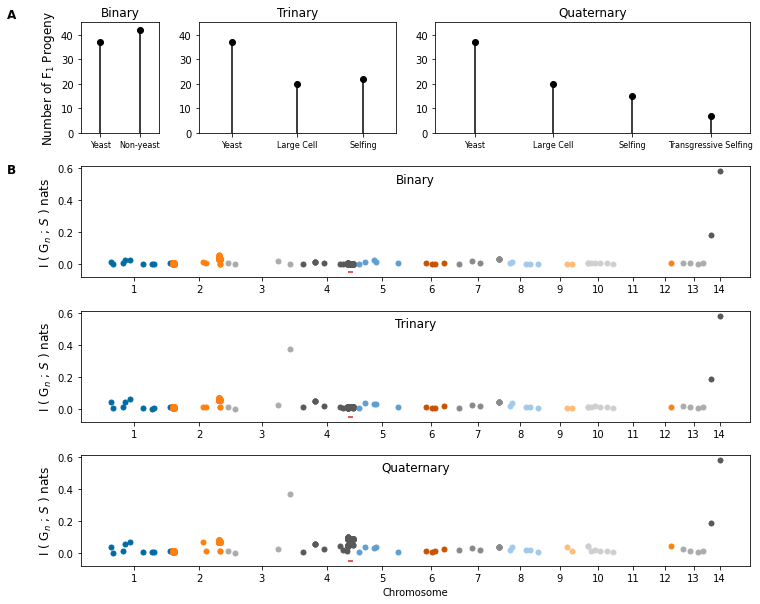

In [17]:
fig = plt.figure(figsize=(12,10))
fig.set_facecolor('w')

gs = fig.add_gridspec(4, 6)

f_ax1 = fig.add_subplot(gs[0,0])
f_ax2 = fig.add_subplot(gs[0,1:3])
f_ax3 = fig.add_subplot(gs[0,3:])

axes = [f_ax1,f_ax2,f_ax3]

    ## Iterate thur phenotypes
for i,pheno_label in enumerate(pheno.columns[5:-2]):
    
    plt.sca(axes[i])
    
    phc = pheno.groupby([pheno_label]).count()['Strain'].values

    plt.vlines(np.arange(len(phc)),np.zeros(len(phc)),phc,color='k')
    plt.plot(np.arange(len(phc)),phc,'o',color='k');
    
    plt.xlim(-0.5,len(phc)-0.5)
    plt.ylim(0,45)
    plt.xticks(np.arange(len(phc)),labels[i],fontsize=8)
    plt.ylabel('Number of F$_1$ Progeny' if i == 0 else None,fontsize=12)
    plt.title(pheno_label,fontsize=12)

    
    qtl_ax = fig.add_subplot(gs[i+1,:])
    
    ## Copy loci df and append phenotype set above
    loci = geno[samples].drop_duplicates().copy()
    usnps = geno[samples].drop_duplicates().copy().T
   
    ## Gather phenotype
    usnps['Y'] = pheno.loc[samples,pheno_label]
    
    ## Cunduct QTL mapping
    miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,discrete_features=True)
    loci['MIobs'] = miobs[:-1]
    
    ## Merge with genotype dataframe
    res = geno.merge(loci)
    
    ## draw manhattan
    qtlfun.manhattan(res,pval='MIobs',ms=10,chrmap=chrommap,
                     xlabel='' if i <2 else 'Chromosome',
                     ylabel=None,ax=qtl_ax,fs=10);
    
    plt.hlines(-0.05,*MATcum,color='tab:red')
    plt.ylabel(myylabel+' nats',fontsize=12)
    plt.title(pheno_label,y=0.8,fontsize=12);

plt.subplots_adjust(hspace=0.3,wspace=0.5)

fig.text(0.04,0.886,'A',fontsize=12,fontweight='bold')
fig.text(0.04,0.67,'B',fontsize=12,fontweight='bold')
plt.savefig('../FIGURES/SHENG_B3502_SupplementalFigureS4_ManhattanPlots.pdf',
            dpi=300,bbox_inches='tight');

In [18]:
## Gather unique haplotypes for testing
loci = geno[samples].drop_duplicates()

## Here I have set the phenotype to a quadriaary phenotype
## Uncomment this to analyze a binary phenotype
## Filamentous vs nonfilamentous vs large cells
#pheno_label = 'Binary'
#pheno_label = 'Trinary'
pheno_label = 'Quaternary'

## Copy loci df and append phenotype set above
usnps = loci.copy().T
Y = pheno.loc[samples,pheno_label]
usnps['Y'] = Y
usnps.shape

(73, 72)

In [19]:
## QTL MAPPING!!!
## Single locus effect
miobs = fs.mutual_info_classif(usnps.values,usnps['Y'].values,discrete_features=True)
## append as column to snp dataframe
#res = usnps.T
loci['MIobs'] = miobs[:-1]

## Merge with genotype dataframe
res = geno.merge(loci)

## Print max
res.MIobs.max()

0.5813304245633744

In [20]:
## Conduct permutations to
## establish genome-wide signfiance
## Set thres to None to run this code
thres = 0.12

## Initialise permutatons setting to 10k
perms = []
nperm = 10000

## Conduct permutations if previous threhold is None
if thres is None:
    while len(perms) < nperm:
        
        ## permute phenotypes
        permy = np.random.permutation(Y)
        
        ## add to dataframe
        usnps['Y'] = permy
        
        ## Calcualte mutual information with discrete features
        MIobsp = fs.mutual_info_classif(usnps.values,permy,discrete_features=True)
        
        ## append results
        perms.append(np.max(MIobsp[:-1]))
    
    ## Set alpha and calculate permutations threshold
    alpha = 95 if nperm  == 1000 else 99
    thres = np.percentile(perms,alpha)
        
## print threshold
thres

0.12

In [21]:
## Plot null distribution of association
if (thres is not None) and (len(perms)==nperm):

    plt.hist(perms,alpha=0.5,color='grey');
    plt.xlabel('$I$ ( G$_n$ ; S ) nats',fontsize=12);
    plt.ylabel('Number of Permutations',fontsize=12);
    plt.title('Null Distribution of Association',fontsize=12);
    plt.vlines(thres,0,nperm/6,color='r',alpha=0.5);
    plt.text(thres,nperm/6,'\u03B1 = %s'%(0.05 if alpha == 95 else 0.01),fontsize=12,
         color='k',alpha=0.5,va='bottom',ha='center')
    plt.savefig('../FIGURES/MI_null_dist_%s.png'%nperm,
            dpi=100,bbox_inches='tight');

In [22]:
## Number of variants on chrom 4 but not in mat locus
geno[(geno.Chrom==4) & (geno.Pos<(1500*1000))].shape[0]

7

In [23]:
## Number of variants in MAT
in_mat = geno[(geno.Chrom==4) & (geno.Pos>=1500000)]
in_mat.shape[0]/geno.shape[0]

0.7089305402425579

In [24]:
## Number of variants in left chrom 2
in_chr2_left = geno[(geno.Chrom==2) & (geno.Pos<=(200*1000))]
in_chr2_left.shape[0]/geno.shape[0]

0.13836824696802646

In [25]:
## Number of variants in left chrom 2
in_chr2_right = geno[(geno.Chrom==2) & (geno.Pos>(1200*1000))]
in_chr2_right.shape[0]/geno.shape[0]

0.11962513781697905

In [26]:
## Number of variants outside of the chromosome 2 arrays and the MAT locus
geno[~(geno.index.isin(in_mat.index)) & 
     ~(geno.index.isin(in_chr2_left.index)) & 
     ~(geno.index.isin(in_chr2_right.index))].shape[0]/geno.shape[0]

0.03307607497243661

In [27]:
## Set chromcolors
chromcolors = qtlfun.qtlcolormap

In [28]:
## MAke a cumlative vector
MATcum = MAT+chrommap[(chrommap.Chromosome==4)].Cumlen.min()

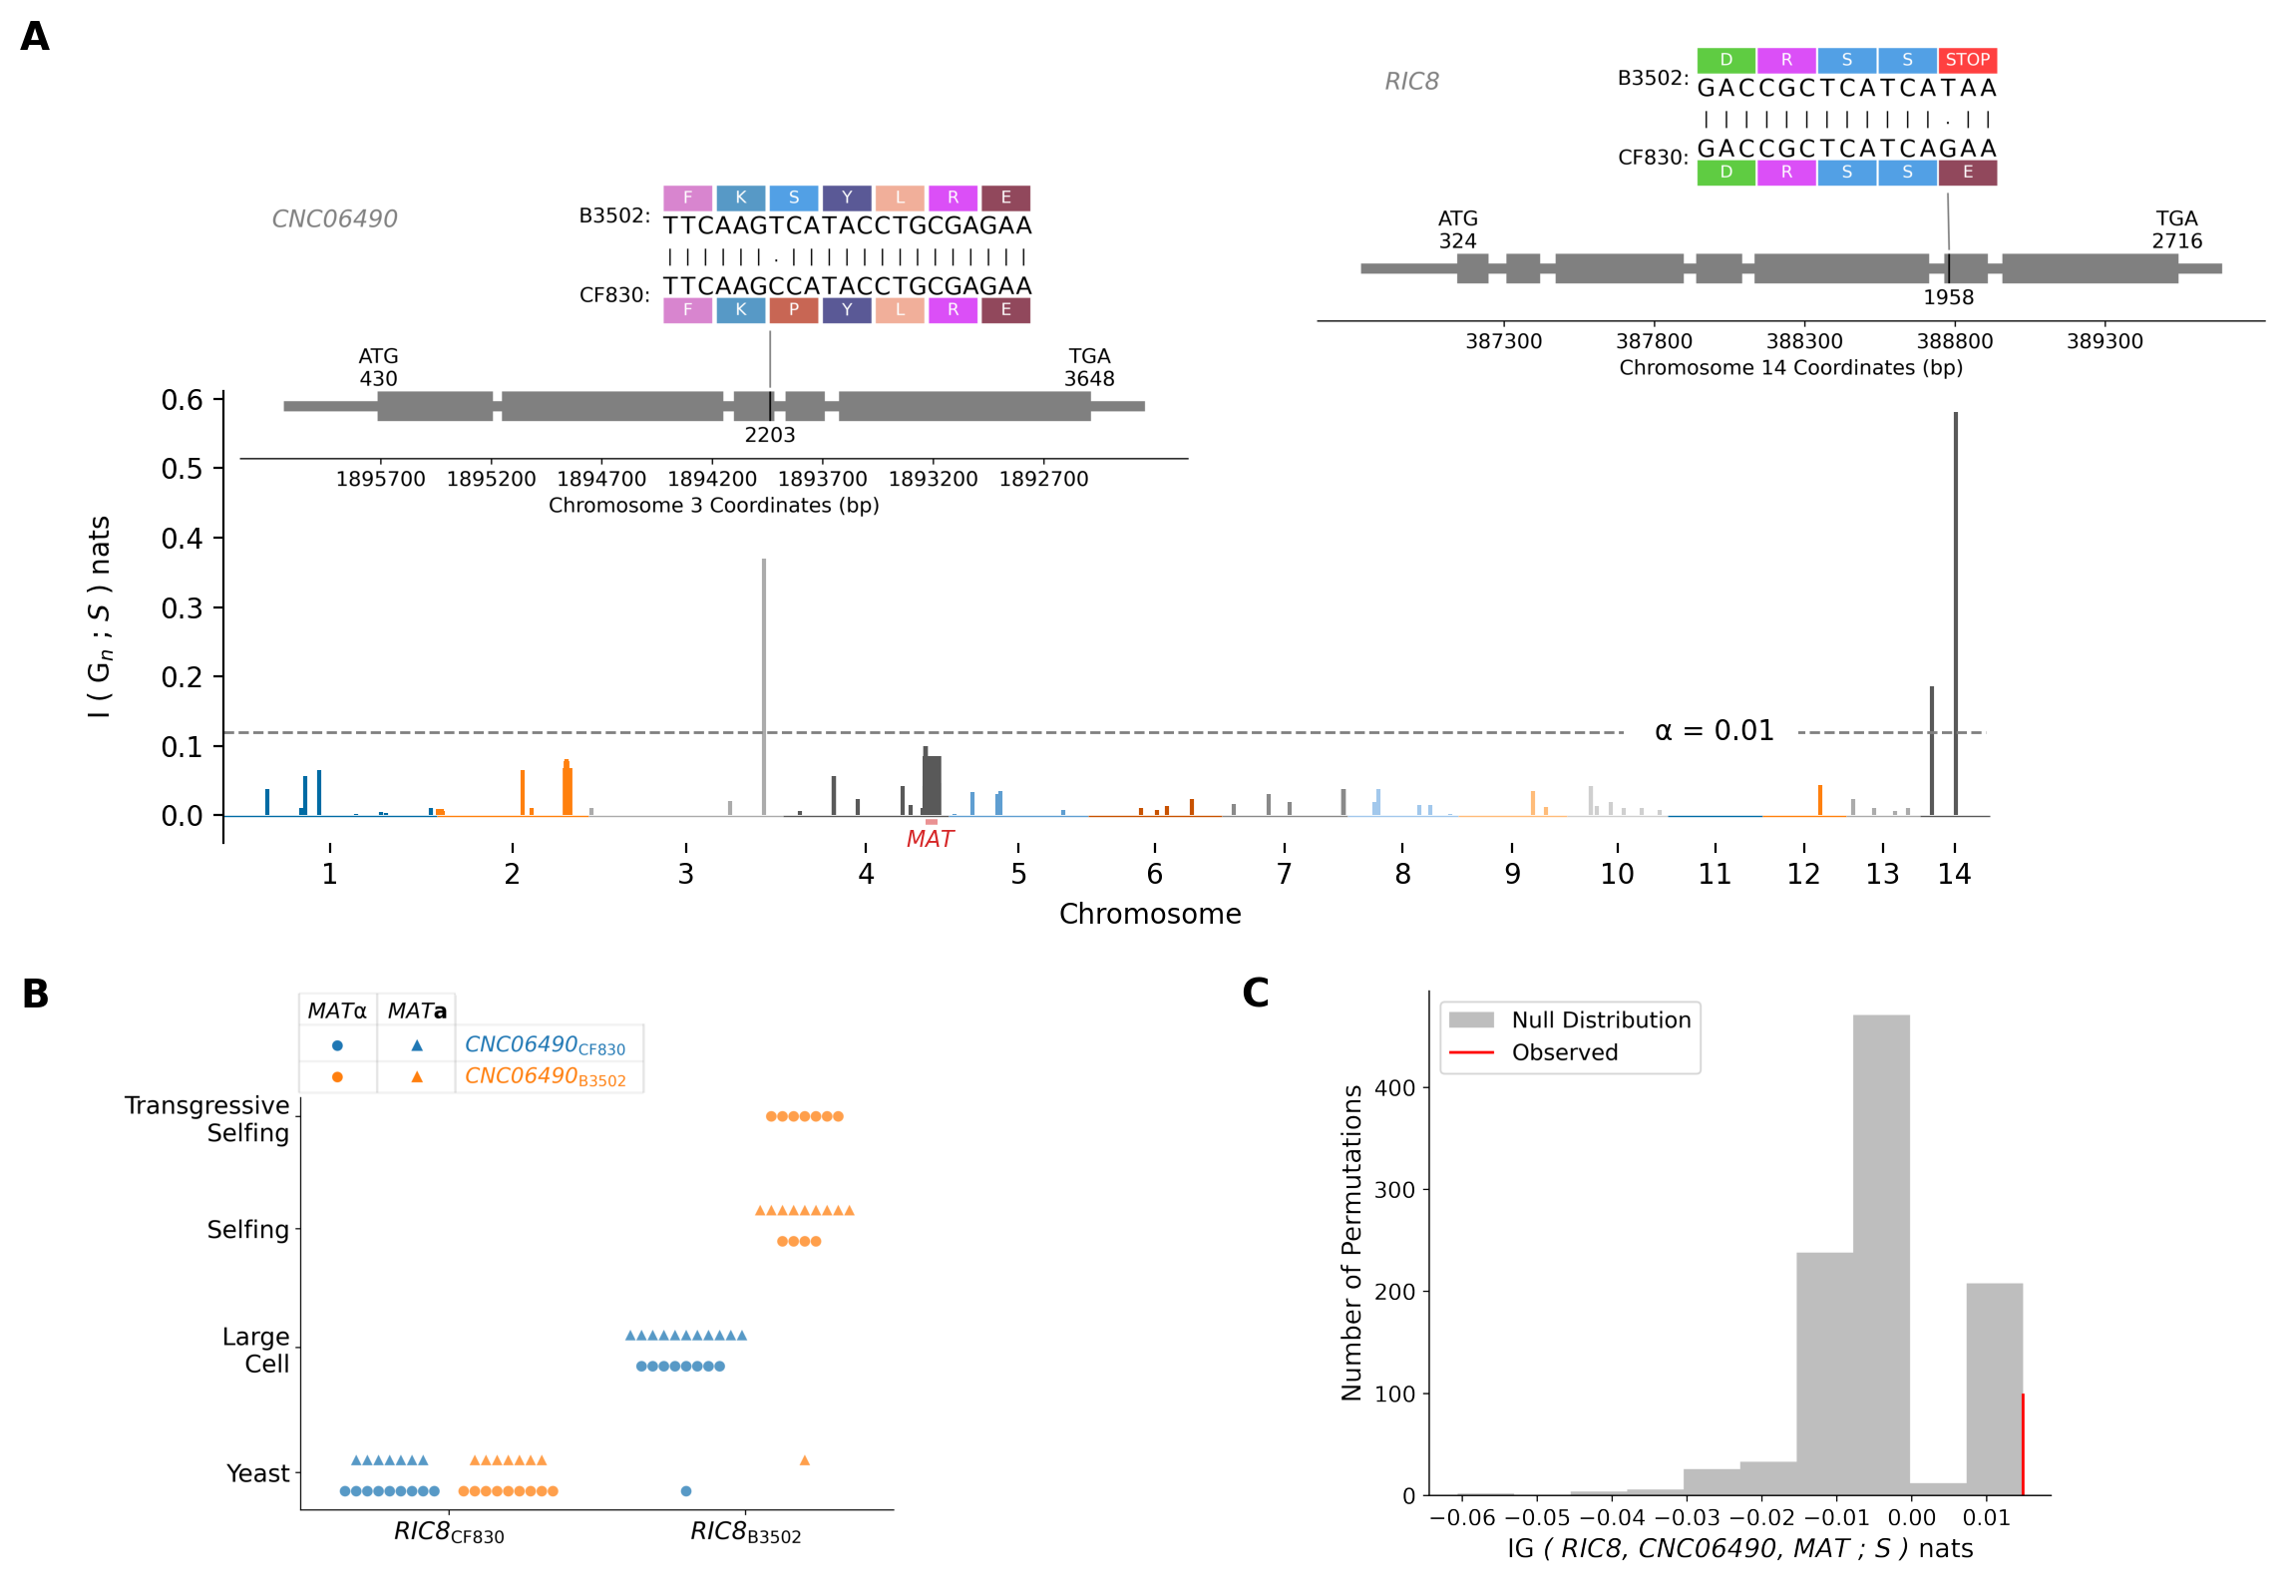

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,3),dpi=200)

for i, cr in chrommap.iterrows():
    
    chromcolor = chromcolors[i%len(chromcolors)]
    chrom = cr.Chromosome
    temp = res[(res.Chromosome==chrom)]
    plt.vlines(temp.Pos+temp.Cumlen,0,temp.MIobs,
               color=chromcolor,rasterized=True)
    plt.hlines(-0.001,cr.Cumlen,cr.Cumlen+cr.Length,
               linewidth=0.5,color=chromcolor,rasterized=True)
    
plt.hlines(thres,0,19*10**6,linewidth=1,linestyle='--',color='grey')
plt.xticks(chrommap.Midpts,chrommap.Chromosome,fontsize=10);
plt.xlim(0)
plt.xlabel('Chromosome',fontsize=10)
plt.ylabel(myylabel + ' nats\n',fontsize=10)

## Plot 
plt.hlines(-0.01,*MATcum,color='tab:red',linewidth=2,alpha=0.5)
plt.text(np.mean(MATcum),-0.02, s='$MAT$', ha='center',va='top',
         color='tab:red',transform=ax.transData,fontsize=8)

plt.hlines(thres,chrommap.Midpts[9]+70000,chrommap.Midpts[11]-70000,color='w')
plt.text(chrommap.Midpts[10],thres,'\u03B1 = %s'%0.01,
         fontsize=10,va='center',ha='center')

## Remove spines
[ax.spines[t].set_visible(False) for t in ['top','right','bottom']]

## Add axis for rho
rhobox = [-0.02,0.65,0.7,0.6]
rhoax = fig.add_axes(rhobox)
img = mpimg.imread('../FIGURES/SHENG_B3502_Figure4_QTGs_A_CNC06490.png')
plt.sca(rhoax)
imgplot = plt.imshow(img)
plt.axis('off')

## Add axis for ric8
ricbox = [0.43,0.88,0.7,0.6]
ricax = fig.add_axes(ricbox)
img = mpimg.imread('../FIGURES/SHENG_B3502_Figure4_QTGs_A_CNN01270.png')
plt.sca(ricax)
imgplot = plt.imshow(img)
plt.axis('off');

## Add axis for phenotype by genotype plot
tilebox = [-0.26,-1.1,1,1]
tileax = fig.add_axes(tilebox)
img = mpimg.imread('../FIGURES/SHENG_B3502_Figure4_QTGs_B.png')
plt.sca(tileax)
imagplot = plt.imshow(img)
plt.axis('off')

## Add axis for null dist of three-way IG
distbox = [0.24,-1.1,1,1]
distax = fig.add_axes(distbox)
img = mpimg.imread('../FIGURES/SHENG_B3502_Figure4_QTGs_C.png')
plt.sca(distax)
imagplot = plt.imshow(img)
plt.axis('off')

## SEction Lables
fig.text(0.04,1.45,'A',fontsize=14,fontweight='bold')
fig.text(0.04,-0.15,'B',fontsize=14,fontweight='bold')
fig.text(0.55,-0.15,'C',fontsize=14,fontweight='bold')

## Save figure
plt.savefig('../FIGURES/SHENG_B3502_Figure4_QTGs.pdf',
            dpi=300, bbox_inches='tight');

In [30]:
## Gather progeny and strain names
## Gather index of column names
mafix = geno.columns.tolist().index('MAF')
lenix = geno.columns.tolist().index('Length')

## Set strains
strains = geno.columns[mafix+1:lenix]

## Gather progeny
progeny = sorted([s for s in strains if len(s)<=4])

## Gather ancestors
ancestors = sorted([s for s in strains if len(s)>4])

## Check work
assert len(progeny) + len(ancestors) == len(strains)

## Gather B3502 stocks
b3502 = [s for s in ancestors if s.split("_")[0]=='B3502']

## parents and progenitor strains
progenitors = [s for s in ancestors if s not in b3502]

In [31]:
## Find loci above threshold and print to screen
sigloci = res[(res.MIobs>=thres)]

## View loci information
sigloci[['Chrom','Pos','Alleles','MAF','MIobs']]

,Chrom,Pos,Alleles,MAF,MIobs
482,3,1894056,G.A,0.434783,0.370218
1812,14,134798,G.C,0.500000,0.185381
1813,14,388777,TCAG.TCAT,0.467391,0.581330


In [32]:
## drop clones
pheno.drop(pheno[(pheno.Clone==1)].index,axis=0,inplace=True)

## append Genotypes of QTL and MAT
pheno.loc[pheno.index,'IRK7'] = sigloci[(sigloci.Chrom==14) & (sigloci.Pos<200000)][pheno.index].values[0]
pheno.loc[pheno.index,'RIC8'] = sigloci[(sigloci.Chrom==14) & (sigloci.Pos>300000)][pheno.index].values[0]
pheno.loc[pheno.index,'RHO'] = sigloci[(sigloci.Chrom==3)][pheno.index].values[0]
pheno.loc[pheno.index,'MAT'] = np.round(geno[(geno.Chrom==4) & (geno.Pos>=np.min(MAT)) & (geno.Pos<=np.max(MAT))][pheno.index].mean(),1)

## Save out data frame
pheno.to_csv("../PHENOTYPE/PROCESSED/Cellsize_shape_phenotype_QTL.csv.gz",index=False)

In [33]:
## What is the variation explained 
## at the RIC8 locus
ric8_r, ric8_pval = ss.pearsonr(pheno[pheno_label].values, pheno.RIC8.values)

## Print the r-squared and associated p-value
ric8_r**2, ric8_pval

(0.6265766454199743, 7.69075474163229e-17)

In [34]:
## What is the variation explianed at the 
## RHO locus
rho_r, rho_pval = ss.pearsonr(pheno[pheno_label].values,pheno.RHO.values)

## Print the r-squared and the assoicated p-value
rho_r**2, rho_pval

(0.13533451438906652, 0.0013648287361335961)